In [102]:
import numpy as np
import os
import os.path
import matplotlib.pyplot as plt

In [106]:
def plot_histogram(histogram, bins, label):
    _, axes1 = plt.subplots(figsize=(20,10))
    axes1.bar(range(len(histogram)), histogram)
    axes1.set_xticks(range(len(histogram)))
    axes1.set_xticklabels(np.round(bins, decimals=2).astype("str"))
    axes1.set_title(label)
    axes2 = axes1.twinx()
    axes2.plot(range(len(histogram)), np.cumsum(histogram) / np.sum(histogram), color="red")
    plt.show()

474
0.7906962025316456
0.8335864978902954


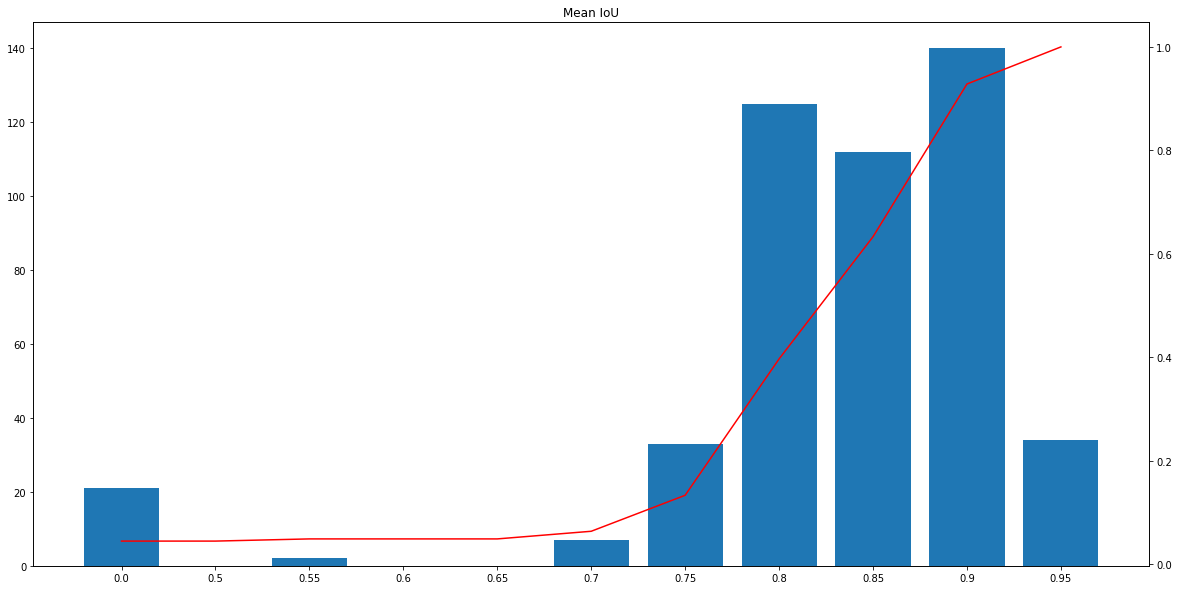

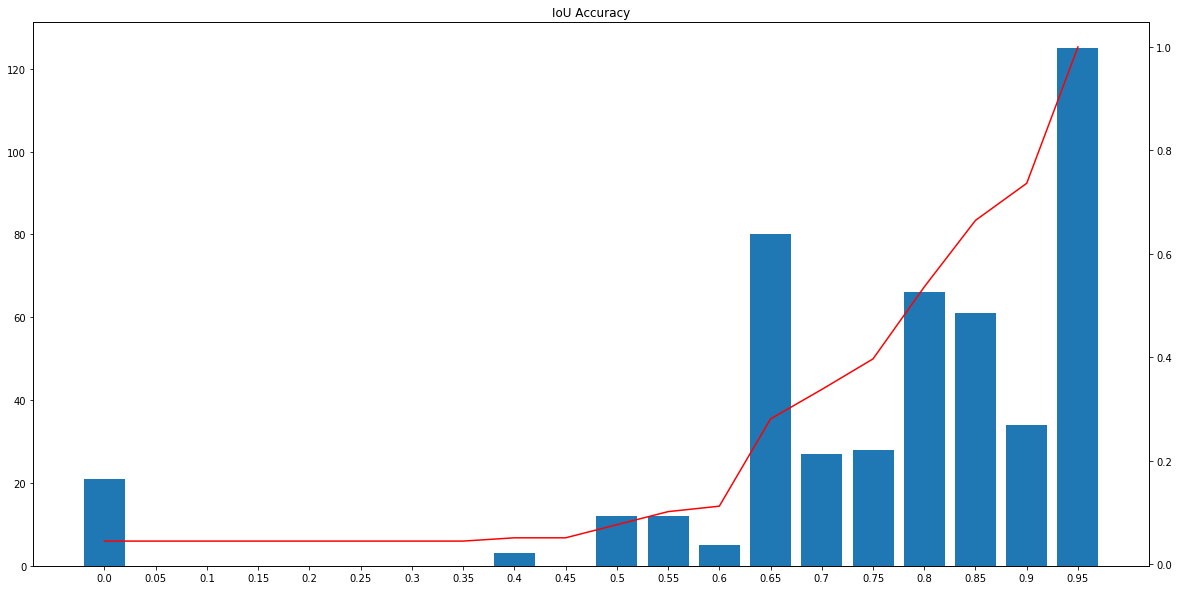

In [107]:
oracle_folder = "/home/apolloxps/apollo/oracle"
debug_folder = "/home/apolloxps/apollo/debug_output"

assert os.path.isdir(oracle_folder)
assert os.path.isdir(debug_folder)

oracle_files_names = sorted([a for a in os.listdir(oracle_folder) if a.endswith("txt")])
debug_files_names = sorted(os.listdir(debug_folder))

def get_rects(file_path):
    rects = []
    with open(file_path) as pred_file:
        lines = pred_file.readlines()
        detected_objects = int(lines[1])
        for i in range(2, detected_objects + 2):
            obj = lines[i].strip()
            params = obj.split(" ")
            rect = params[:4]
            rects.append([int(x) for x in rect])
    return rects

def compute_frame_accuracy(oracle_rects, debug_rects):
    taken = []
    ious = []
    for x, y, w, h in oracle_rects:
        
        x1_o, x2_o, y1_o, y2_o = x, x + w, y, y + h
        max_iou = 0
        max_taken = -1
        
        for k in range(len(debug_rects)):
            if k in taken:
                continue
            x_d, y_d, w_d, h_d = debug_rects[k]
            x1_d, x2_d, y1_d, y2_d = x_d, x_d + w_d, y_d, y_d + h_d
            
            x1_i = max(x1_o, x1_d)
            y1_i = max(y1_o, y1_d)
            x2_i = min(x2_o, x2_d)
            y2_i = min(y2_o, y2_d)
            
            intersection_area = max(0, x2_i - x1_i + 1) * max(0, y2_i - y1_i + 1)
            union_area = (x2_o - x1_o + 1) * (y2_o - y1_o + 1) + (x2_d - x1_d + 1) * (y2_d - y1_d + 1)
            iou = intersection_area / (union_area - intersection_area)
            if iou > max_iou:
                max_iou = iou
                max_taken = k

        if max_iou > 0.5:
            ious.append(max_iou)
            taken.append(max_taken)
        ious_accuracy = len(ious) / (len(oracle_rects) + len(debug_rects) - len(ious))
    if len(ious) > 0:
        tp = len(ious)
        fn = len(oracle_rects) - tp
        fp = len(debug_rects) - tp
        p = tp / (tp + fp)
        r = tp / (tp + fn)
        f = 2 * ((p * r) / (p + r))
        return ious, np.round(f, decimals=2), np.round(np.mean(np.array(ious)), decimals=2)     
    else:
        return [], 0, 0

def plots(ious_accuracies, mean_ious):
    _, axes1 = plt.subplots(figsize=(20,10))
    axes1.plot(range(len(mean_ious)), mean_ious, "o")
    axes2 = axes1.twinx()
    axes2.plot(range(len(ious_accuracies)), ious_accuracies, "o", color="red")
    plt.show()

print(len(oracle_files_names))
assert oracle_files_names == debug_files_names

ious_accuracies = []
mean_ious = []

for fn in oracle_files_names:
    oracle_rects = get_rects(os.path.join(oracle_folder, fn))
    debug_rects = get_rects(os.path.join(debug_folder, fn))
    _, ious_accuracy, mean_iou = compute_frame_accuracy(oracle_rects, debug_rects)
    ious_accuracies.append(ious_accuracy)
    mean_ious.append(mean_iou)
    
print(np.mean(np.array(ious_accuracies)))
print(np.mean(np.array(mean_ious)))

unique_values = np.array([0] + [0.5 + i * 0.05 for i in range(0, 11)])
histogram, bins = np.histogram(np.array(mean_ious), unique_values)#np.linspace(min(unique_values), max(unique_values), num=len(unique_values)))
plot_histogram(histogram, bins[:-1], "Mean IoU")

unique_values = np.linspace(0.0, 1.0, 21)
histogram, bins = np.histogram(np.array(ious_accuracies), unique_values)#np.linspace(min(unique_values), max(unique_values), num=len(unique_values)))
plot_histogram(histogram, bins[:-1], "IoU Accuracy")